In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import joypy
import os
import sys
import json
from scipy import stats
import matplotlib.lines as lines

sys.path.insert(1, "/home/ec753/Projects/NST_experiment/utils/")
import HH

## load data

In [2]:
data_dir = './data/partial_history/'

In [16]:
with open(f'{data_dir}stimuli.json') as f:
    stimuli = json.load(f)

In [18]:
histories_base = np.load(f'{data_dir}histories_base.npy')
histories_lw = np.load(f'{data_dir}histories_lw.npy')
histories_lt = np.load(f'{data_dir}histories_lt.npy')
histories_lwlt = np.load(f'{data_dir}histories_lwlt.npy')
histories_burst = np.load(f'{data_dir}histories_burst.npy')
histories_sets = {
    'base': histories_base,
    'lw': histories_lw,
    'lt': histories_lt,
    'lwlt': histories_lwlt,
    'burst': histories_burst
}

In [53]:
results_files = os.listdir(f'{data_dir}results')
print(f'number of results files: {len(results_files)} / {5*28*1000}')

results = {
    'base':{n:{} for n in range(3,31)},
    'lw':{n:{} for n in range(3,31)},
    'lt':{n:{} for n in range(3,31)},
    'lwlt':{n:{} for n in range(3,31)},
    'burst':{n:{} for n in range(3,31)},
}

progress = 0.0
print('______PROGRESS______')
for i, results_file in enumerate(results_files):
    stim_type = results_file.split('_')[0]
    n = int(results_file.split('_')[1])
    pattern_id = int(results_file.split('_')[2].strip('.npy'))
    
    results[stim_type][n][pattern_id] = np.load(f'{data_dir}results/{results_file}')
    
    if i / len(results_files) > progress:
        progress += 0.05
        print('=', end='')

number of results files: 103091 / 140000
______PROGRESS______

In [27]:
results['base']

17439

In [47]:
def calc_spike_presence_prediction_acc(df):
    no_spike = np.sum(np.isnan(df))
    spike = df.shape[0] - no_spike
    return (no_spike/df.shape[0])**2 + (spike/df.shape[0])**2

def calc_nst_std(df):
    return np.std(df[~np.isnan(df)])

In [54]:
spike_presence_prediction_accs = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)}
}
nst_stds = {
    'base': {n:[] for n in range(3,31)},
    'lw': {n:[] for n in range(3,31)},
    'lt': {n:[] for n in range(3,31)},
    'lwlt': {n:[] for n in range(3,31)},
    'burst': {n:[] for n in range(3,31)}
}


for stim_type in results:
    for n in range(3,31):
        for pattern_ind in range(1000):
            try:
                df = results[stim_type][n][pattern_ind]
                spike_presence_prediction_accs[stim_type][n].append(calc_spike_presence_prediction_acc(df))
                nst_stds[stim_type][n].append(calc_nst_std(df))
            except:
                pass

In [69]:
spike_presence_prediction_acc_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': []
}
nst_std_means = {
    'base': [],
    'lw': [],
    'lt': [],
    'lwlt': [],
    'burst': []
}
for stim_type in spike_presence_prediction_accs:
    for n in range(3,31):
        spike_presence_prediction_acc_means[stim_type].append(np.mean(spike_presence_prediction_accs[stim_type][n]))
        
        nst_std_means[stim_type].append(np.nanmean(nst_stds[stim_type][n]))

In [83]:
list(colors.keys())

['base', 'lw', 'lt', 'lwlt', 'burst']

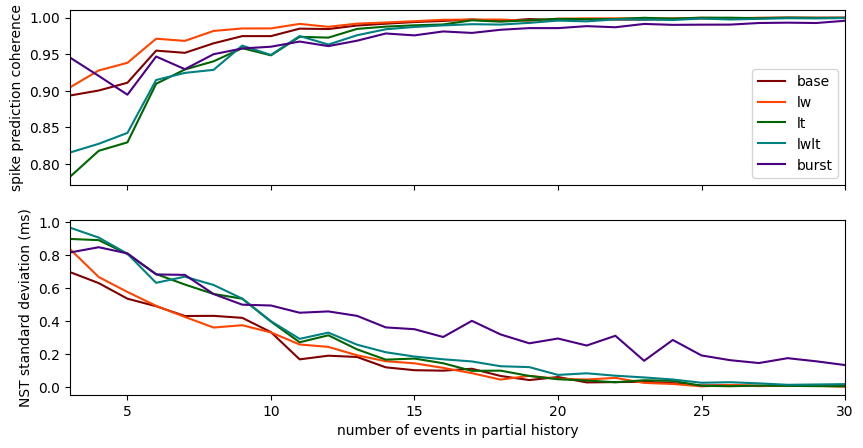

In [85]:
colors = {
    'base': 'maroon',
    'lw': 'orangered',
    'lt': 'darkgreen',
    'lwlt': 'teal',
    'burst': 'indigo'
}
ns = np.arange(3,31,1)

fig, axes = plt.subplots(2,1, figsize=(10,5), sharex=True)
for stim_type in spike_presence_prediction_acc_means:
    axes[0].plot(ns, spike_presence_prediction_acc_means[stim_type], c=colors[stim_type])
    
    axes[1].plot(ns, nst_std_means[stim_type], c=colors[stim_type])

axes[-1].set_xlim(3,30)

axes[0].set_ylabel('spike prediction coherence')
axes[1].set_ylabel('NST standard deviation (ms)')
axes[1].set_xlabel('number of events in partial history')
axes[0].legend(list(colors.keys()))
plt.show()

In [2]:
data_dir = './n_inputs_prediction_output/'

In [3]:
# load sim data
sim_events = pd.read_csv(
    data_dir+'sim_data/events.csv', 
    names=['event_type','event_time'], dtype={'event_type': 'str', 'event_time': np.float64})
sim_df = pd.read_csv(data_dir+'sim_data/sim_df.csv', index_col=0)
with open(data_dir+'sim_data/spikes.csv', 'r') as fin:
    sim_spikes = [float(line.strip()) for line in fin.readlines()]

In [4]:
# load test results
results = pd.read_csv(data_dir+'results/results.csv', header=None, names=['t0_ind','n','history_ind','nst'])
results

,t0_ind,n,history_ind,nst
0,766,2,0,NaN
1,766,2,1,1.474803
2,766,2,2,NaN
3,766,2,3,2.099803
4,766,2,4,1.549803
...,...,...,...,...
37999995,1865,20,995,NaN
37999996,1865,20,996,NaN
37999997,1865,20,997,NaN
37999998,1865,20,998,NaN


In [5]:
n_input_nst_dists = []
for n in range(2,20):
    n_input_nst_dists.append(results[results['n']==n]['nst'])
n_input_nst_dists_df = pd.DataFrame({i+2:n_input_nst_dists[i] for i in range(len(n_input_nst_dists))})

In [5]:
n_input_nst_dists_im = []
bins = np.arange(0, 10, .1)
for i in range(len(n_input_nst_dists)):
    _hist, _bins = np.histogram(n_input_nst_dists[i][~np.isnan(n_input_nst_dists[i])], bins=bins)
    n_input_nst_dists_im.append(_hist)
n_input_nst_dists_im = np.array(n_input_nst_dists_im)

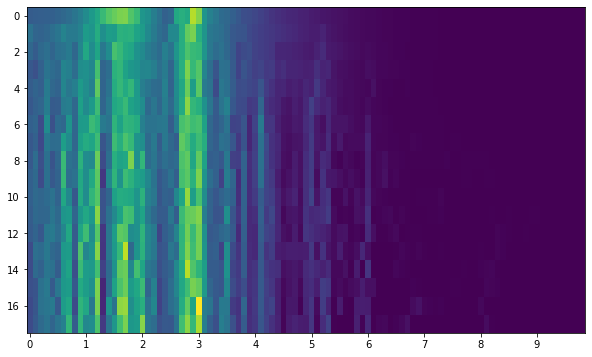

In [6]:
plt.figure(figsize = (10,6))
plt.imshow(n_input_nst_dists_im, aspect='auto')
plt.xticks(np.arange(0,100,10), np.arange(0, 10, 1))
plt.show()

In [ ]:
# takes a long time to run
# maybe try taking out the extra nans as the ordering doesn't matter

#fig, axes = joypy.joyplot(n_input_nst_dists_df, overlap=2, linecolor='w', linewidth=.5, figsize=(6,10))

## look at NST distributions

In [ ]:
_slice = results[results['t0_ind']==766]

n_input_nst_dists_TEST = []
for n in range(2,20):
    n_input_nst_dists_TEST.append(_slice[_slice['n']==n]['nst'])
n_input_nst_dists_df_TEST = pd.DataFrame(
    {i+2:n_input_nst_dists_TEST[i] for i in range(len(n_input_nst_dists_TEST))}
)
fig, axes = joypy.joyplot(n_input_nst_dists_df_TEST, overlap=2, linecolor='w', linewidth=.5, figsize=(6,10))

## compare with including time of last spike

In [39]:
def color_event(event_type):
    if event_type == 'e':
        return 'red'
    elif event_type == 'i':
        return 'blue'
    elif event_type == 'o':
        return 'green'
    else:
        print('oops')
        return 

539


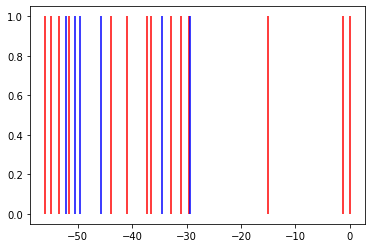

In [375]:
# example
spiking_t0_inds = [400, 1203]
non_spiking_t0_inds = [121, 94, 1456]
interesting_t0_inds = [1356]
t0_ind = np.random.randint(20, 1610)
print(t0_ind)
t0_ind=63

sample_events = sim_events.iloc[t0_ind-20: t0_ind, :]
# plot raster
stim_types = sample_events['event_type']
stim_times = [stim - max(sample_events['event_time']) for stim in sample_events['event_time']]

plt.vlines(stim_times, 0, 1, colors=[color_event(stim) for stim in stim_types])
plt.show()

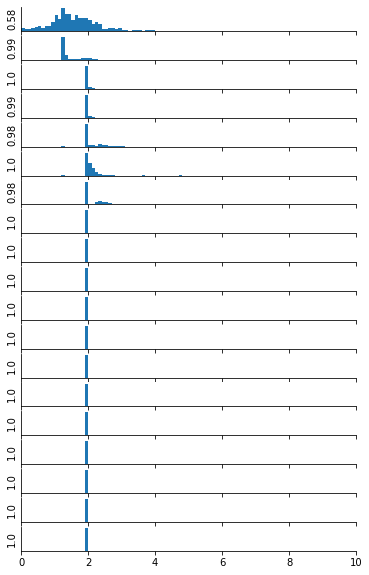

In [376]:
sample_results = results[results['t0_ind'] == t0_ind]
n_stop = 21

fig, axes = plt.subplots(n_stop-2,1, figsize=(6,10), sharex=True)
bins = np.arange(0,10, .1)

for axes_ind, n in enumerate(range(2, n_stop)):
    axes[axes_ind].hist(sample_results[sample_results['n'] == n]['nst'], bins=bins)
    axes[axes_ind].set_ylabel(
        round(np.sum(~np.isnan(sample_results[sample_results['n'] == n]['nst'])) / sample_results[sample_results['n'] == n].shape[0] , 2))
    # aesthetics
    axes[axes_ind].spines['top'].set_visible(False)
    axes[axes_ind].spines['right'].set_visible(False)
    axes[axes_ind].set_yticks([])
    
axes[-1].set_xlim(0, 10)
plt.show()

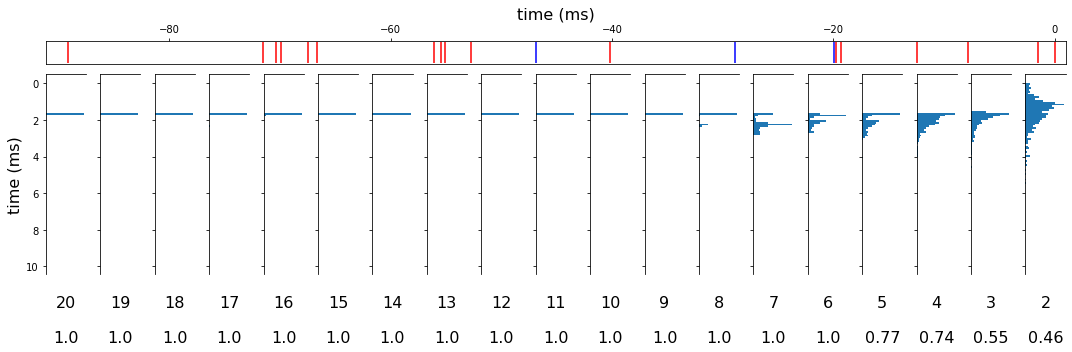

In [264]:
def plot_example_nst_hist_evolution(t0_ind, n_stop=21):
    # something funky about passing in the correct t0_ind and it messing it up for the existing variable outside
    sample_events = sim_events.iloc[t0_ind-20: t0_ind, :]
    # plot raster
    stim_types = sample_events['event_type']
    stim_times = [stim - max(sample_events['event_time']) for stim in sample_events['event_time']]
    
    hist_axes = [str(ind) for ind in range(2,21)]
    hist_axes.reverse()
    
    gs_kw = dict( height_ratios=[.1, .9])
    fig, axd = plt.subplot_mosaic(
        [['raster']*19, hist_axes],
        gridspec_kw=gs_kw, figsize=(15, 5),
        )
    
    # raster
    axd['raster'].vlines(stim_times, 0, 1, colors=[color_event(stim) for stim in stim_types])
    axd['raster'].xaxis.tick_top()
    axd['raster'].set_yticks([])
    axd['raster'].set_xlim(min(stim_times)-2, 1)
    axd['raster'].set_title('time (ms)', fontsize=16)
    
    # histograms
    for n in range(2, n_stop):
        axd[str(n)].hist(sample_results[sample_results['n'] == n]['nst'], bins=bins, orientation="horizontal")
        spike_freq = round(np.sum(~np.isnan(sample_results[sample_results['n'] == n]['nst'])) /
                           sample_results[sample_results['n'] == n].shape[0] , 2)
        axd[str(n)].set_xlabel('\n'+str(n)+'\n\n'+str(spike_freq), fontsize=16)
        # aesthetics
        axd[str(n)].spines['bottom'].set_visible(False)
        axd[str(n)].spines['right'].set_visible(False)
        axd[str(n)].invert_yaxis()
        axd[str(n)].set_xticks([])
        if n < n_stop - 1:
            axd[str(n)].set_yticklabels([])
        else:
            axd[str(n)].set_ylabel('time (ms)', fontsize=16)
            
    
    fig.tight_layout()
    plt.show()
        
plot_example_nst_hist_evolution(400)

## calculate ks test

In [266]:
results_sorted = results.sort_values(by='t0_ind')

In [267]:
# takes ~20secs to run
spike_ratios = []
ks_results = []
# isolate each instance of the data
for i in range(len(list(set(results['t0_ind'])))):
    _slice = results.iloc[19000*i:19000*(i+1)]
    spike_ratio = np.sum(~np.isnan(_slice['nst'])) / 19000
    
    spike_ratios.append(spike_ratio)
    
    _ks_results = []
    for axes_ind, n in enumerate(range(2, 20)):
        n_samp = _slice[_slice['n'] == n]['nst'] # nth sample
        np1_samp = _slice[_slice['n'] == n+1]['nst'] # n+1 sample
        ks_res = stats.kstest(n_samp, np1_samp)
        _ks_results.append(ks_res.statistic)
    ks_results.append(_ks_results)

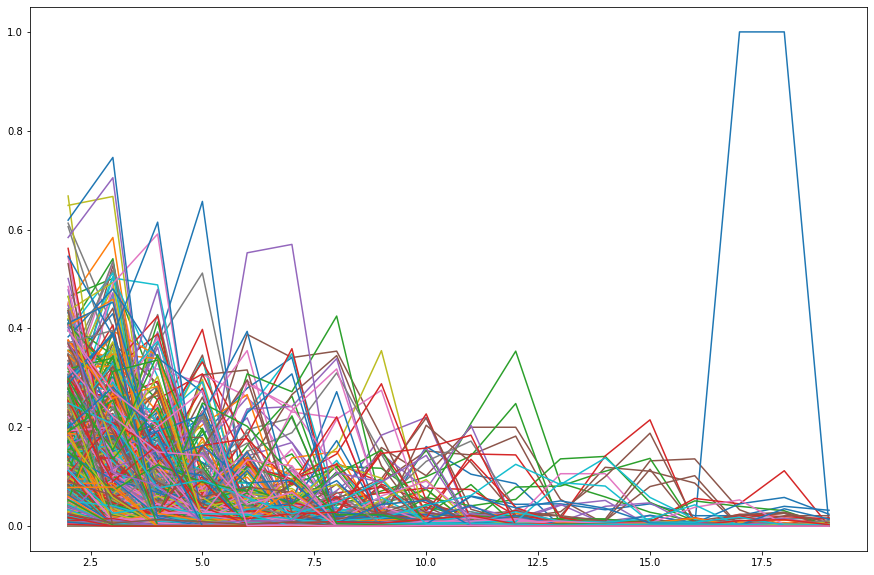

In [268]:
plt.figure(figsize=(15,10))
for i, ks_result in enumerate(ks_results):
    if spike_ratios[i] < 0.1:
        plt.plot(range(2,20), ks_result)

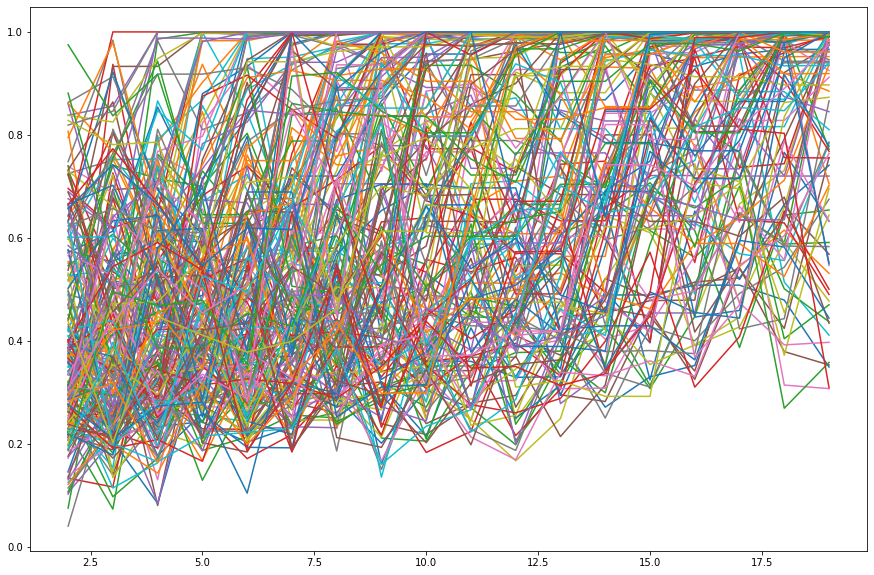

In [269]:
plt.figure(figsize=(15,10))
for i, ks_result in enumerate(ks_results):
    if spike_ratios[i] > 0.9:
        plt.plot(range(2,20), ks_result)

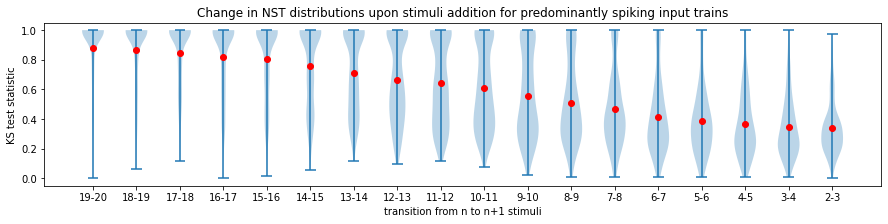

In [344]:
plt.figure(figsize=(15,3))
spike_ks = [x for i, x in enumerate(ks_results) if spike_ratios[i] > 0.5]
spike_ks_inverted = [[spike_ks[i][j] for i in range(len(spike_ks))]  for j in range(0,18)]
plt.violinplot(spike_ks_inverted, np.arange(20,2,-1))
plt.scatter(np.arange(20,2,-1), np.sum(np.array(spike_ks), axis=0)/len(spike_ks), c='red', zorder=10)
plt.xticks(np.arange(3,21,1), [str(x-1)+'-'+str(x) for x in np.arange(20,2,-1)])
plt.xlabel('transition from n to n+1 stimuli')
plt.ylabel('KS test statistic')
plt.title('Change in NST distributions upon stimuli addition for predominantly spiking input trains')
plt.show()

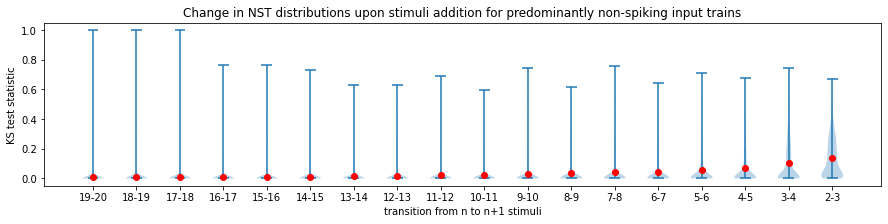

In [345]:
plt.figure(figsize=(15,3))
spike_ks = [x for i, x in enumerate(ks_results) if spike_ratios[i] < 0.5]
spike_ks_inverted = [[spike_ks[i][j] for i in range(len(spike_ks))]  for j in range(0,18)]
plt.violinplot(spike_ks_inverted, np.arange(20,2,-1))
plt.scatter(np.arange(20,2,-1), np.sum(np.array(spike_ks), axis=0)/len(spike_ks), c='red', zorder=10)
plt.xticks(np.arange(3,21,1), [str(x-1)+'-'+str(x) for x in np.arange(20,2,-1)])
plt.xlabel('transition from n to n+1 stimuli')
plt.ylabel('KS test statistic')
plt.title('Change in NST distributions upon stimuli addition for predominantly non-spiking input trains')
plt.show()

## calc mutual information

In [328]:
def calc_MI(X,Y,bins):
    c_XY = np.histogram2d(X,Y,bins)[0]
    c_X = np.histogram(X,bins)[0]
    c_Y = np.histogram(Y,bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    return MI

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

## this MI code is producing negative values, which is a nono

In [329]:
spike_ratios = []
ks_results = []
# isolate each instance of the data
for i in range(len(list(set(results['t0_ind'])))):
    _slice = results.iloc[19000*i:19000*(i+1)]
    spike_ratio = np.sum(~np.isnan(_slice['nst'])) / 19000
    
    spike_ratios.append(spike_ratio)
    
    _ks_results = []
    for axes_ind, n in enumerate(range(2, 20)):
        n_samp = _slice[_slice['n'] == n]['nst'] # nth sample
        np1_samp = _slice[_slice['n'] == n+1]['nst'] # n+1 sample
        ks_res = stats.kstest(n_samp, np1_samp)
        _ks_results.append(ks_res.statistic)
    ks_results.append(_ks_results)

In [374]:
t0_ind = 63
_slice = results[results['t0_ind']==t0_ind]
print(_slice['t0_ind'].iloc[0])

MIs = []
for axes_ind, n in enumerate(range(2, 20)):
    n_samp = _slice[_slice['n'] == n]['nst'] # nth sample
    np1_samp = _slice[_slice['n'] == n+1]['nst'] # n+1 sample
    mi = calc_MI(n_samp, np1_samp, bins)
    MIs.append(mi)
print([mi for mi in MIs])

63
[1.7467674264973114, 0.26659295609447975, 0.4917553224146276, 0.388121180373195, 0.9694510660906599, 0.9283236120402774, 0.08725531605731929, -5.641663864852653e-06, 2.8897258764620792e-06, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [371]:
t0_inds = list(set(results['t0_ind']))
results_MI = []
for t0_ind in t0_inds:
    _slice = results[results['t0_ind']==t0_ind]
    MIs = []
    for axes_ind, n in enumerate(range(2, 20)):
        n_samp = _slice[_slice['n'] == n]['nst'] # nth sample
        np1_samp = _slice[_slice['n'] == n+1]['nst'] # n+1 sample
        mi = calc_MI(n_samp, np1_samp, bins)
        if mi < 0:
            print(mi, t0_ind)
        MIs.append(mi)
    results_MI.append(MIs)

/tmp/ipykernel_668994/1663497821.py:14: RuntimeWarning: invalid value encountered in true_divide
  c_normalized = c / float(np.sum(c))


-5.641663864852653e-06 63
-0.2500028788454851 79
-0.0014680609703892067 87
-0.012551499738720107 88
-0.0001526550427393865 88
-0.0028833700671965223 88
-0.0034379361333417013 88
-0.0030772568258551347 88
-0.0004904143124948024 89
-0.0002196707013231297 89
-0.00705356505424648 89
-0.8505884697361399 90
-0.4062421204777209 115
-0.4038161310197268 117
-0.18923360522213395 118
-2.023000936607292 119
-0.38108923006364925 122
-1.4426412712989132 122
-0.05351991271540585 124
-0.0008909599044750194 124
-0.0914591249848975 134


KeyboardInterrupt: 

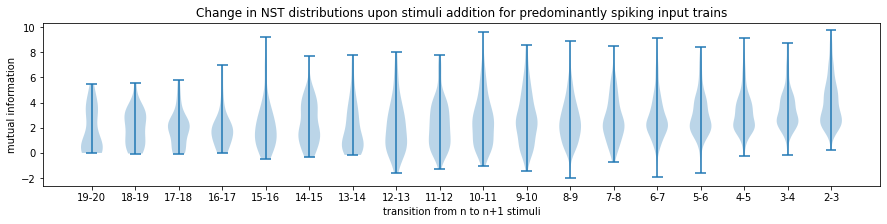

In [351]:
plt.figure(figsize=(15,3))
spike_mi = [x for i, x in enumerate(results_MI) if spike_ratios[i] < 0.5]
spike_mi_inverted = [[spike_mi[i][j] for i in range(len(spike_mi)) if ~np.isnan(spike_mi[i][j])]  for j in range(0,18)] # remove nans
plt.violinplot(spike_mi_inverted, np.arange(20,2,-1))
plt.scatter(np.arange(20,2,-1), np.sum(np.array(spike_mi), axis=0)/len(spike_mi), c='red', zorder=10)
plt.xticks(np.arange(3,21,1), [str(x-1)+'-'+str(x) for x in np.arange(20,2,-1)])
plt.xlabel('transition from n to n+1 stimuli')
plt.ylabel('mutual information')
plt.title('Change in NST distributions upon stimuli addition for predominantly spiking input trains')
plt.show()

In [349]:
spike_mi_inverted

[[3.6351844213004325,
  8.009375921819991,
  nan,
  2.778488801747489,
  2.407033523615146,
  nan,
  0.2868103917386211,
  4.84595089327456,
  2.1341246165143835,
  1.755297179030613,
  1.4313810913441412,
  1.6951171530821956,
  2.424983854176846,
  3.4022688839165927,
  2.3657183512024096,
  4.264235655154018,
  2.289270087515873,
  2.7707041534235985,
  2.2765577331603906,
  0.4126139879494932,
  1.7553835470345387,
  3.5613232441302394,
  2.785212963529781,
  nan,
  3.306410920272744,
  2.6782787787090117,
  2.8108041432779087,
  1.3017241492238427,
  3.5619552444838067,
  3.3683291254945207,
  3.01958220807498,
  0.5370429203556149,
  1.662699946977921,
  2.474386140345768,
  1.5505659591643406,
  1.9797663477746195,
  2.4760413439535416,
  2.4362237410835252,
  3.0837466593529284,
  4.805208222735219,
  1.0178555094930308,
  3.4516553351892405,
  3.226452193392606,
  2.5312246136855956,
  0.3844833479677163,
  0.2724784965599518,
  2.7677492482570383,
  1.6301634851343172,
  3.57